In [1]:
!pip install sentence-transformers

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load CSVs
job_df = pd.read_csv('/Users/apsarasrinivasan/Downloads/job_descriptions.csv')
resume_df = pd.read_csv('/Users/apsarasrinivasan/Downloads/resumes.csv')

# Combine text fields
job_df['combined_text'] = job_df[['Company_Overview', 'Responsibilities', 'Required_Qualifications', 'Preferred_Qualifications']].fillna('').agg(' '.join, axis=1)
resume_df['combined_text'] = resume_df[['Professional_Summary', 'Work_Experience', 'Projects', 'Certifications', 'Education', 'Skills']].fillna('').agg(' '.join, axis=1)

# Load model just to get embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get embeddings and similarity matrix
resume_embeddings = model.encode(resume_df['combined_text'].tolist(), convert_to_numpy=True)
job_embeddings = model.encode(job_df['combined_text'].tolist(), convert_to_numpy=True)
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)
similarity_df = pd.DataFrame(similarity_matrix, index=resume_df['ID'], columns=job_df['ID'])

# Generate training pairs (positives)
train_examples_all = []
for job_id in job_df['ID']:
    top_resumes = similarity_df[job_id].sort_values(ascending=False).head(3).index.tolist()
    job_text = job_df[job_df['ID'] == job_id]['combined_text'].values[0]
    for resume_id in top_resumes:
        resume_text = resume_df[resume_df['ID'] == resume_id]['combined_text'].values[0]
        train_examples_all.append(InputExample(texts=[resume_text, job_text], label=1.0))

# Add random negatives
import random
for _ in range(len(train_examples_all)):
    rand_resume = resume_df.sample(1).iloc[0]
    rand_job = job_df.sample(1).iloc[0]
    train_examples_all.append(InputExample(texts=[rand_resume['combined_text'], rand_job['combined_text']], label=0.0))

# Split again
train_examples, test_examples = train_test_split(train_examples_all, test_size=0.2, random_state=42)

/Users/apsarasrinivasan/anaconda3/envs/nlp_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
print(sys.executable)

/Users/apsarasrinivasan/anaconda3/envs/nlp_project/bin/python


In [4]:
# Generate top-5 ranked resumes per job
all_rankings = []

for job_id in job_df['ID']:
    ranked = similarity_df[job_id].sort_values(ascending=False).reset_index()
    ranked.columns = ['Resume_ID', 'Similarity_Score']
    ranked['Job_ID'] = job_id
    top_ranked = ranked.head(5)
    all_rankings.append(top_ranked)

combined_df = pd.concat(all_rankings, ignore_index=True)
combined_df = combined_df[['Job_ID', 'Resume_ID', 'Similarity_Score']]
combined_df.head(5)

,Job_ID,Resume_ID,Similarity_Score
0,JD0001,R2941,0.646704
1,JD0001,R6887,0.635832
2,JD0001,R2796,0.601652
3,JD0001,R2937,0.592615
4,JD0001,R6312,0.589408


In [5]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Load your fine-tuned model
model = SentenceTransformer('/Users/apsarasrinivasan/fine_tuned_cv_model')

In [6]:
# Recombine text fields if needed
resume_df['combined_text'] = resume_df[['Professional_Summary', 
                                        'Work_Experience', 
                                        'Projects', 
                                        'Certifications', 
                                        'Education', 
                                        'Skills']].fillna('').agg(' '.join, axis=1)

job_df['combined_text'] = job_df[['Company_Overview', 
                                  'Responsibilities', 
                                  'Required_Qualifications', 
                                  'Preferred_Qualifications']].fillna('').agg(' '.join, axis=1)

# Recompute embeddings using the fine-tuned model
resume_embeddings = model.encode(resume_df['combined_text'].tolist(), convert_to_tensor=False)
job_embeddings = model.encode(job_df['combined_text'].tolist(), convert_to_tensor=False)

In [7]:
similarity_matrix = cosine_similarity(resume_embeddings, job_embeddings)
similarity_df = pd.DataFrame(similarity_matrix, index=resume_df['ID'], columns=job_df['ID'])

In [8]:
all_rankings = []

for job_id in job_df['ID']:
    ranked = similarity_df[job_id].sort_values(ascending=False).reset_index()
    ranked.columns = ['Resume_ID', 'Similarity_Score']
    ranked['Job_ID'] = job_id
    top_ranked = ranked.head(5)
    all_rankings.append(top_ranked)

combined_df = pd.concat(all_rankings, ignore_index=True)
combined_df = combined_df[['Job_ID', 'Resume_ID', 'Similarity_Score']]
combined_df.head()

,Job_ID,Resume_ID,Similarity_Score
0,JD0001,R6312,0.976339
1,JD0001,R4572,0.973102
2,JD0001,R2936,0.972355
3,JD0001,R5479,0.970639
4,JD0001,R1381,0.968446


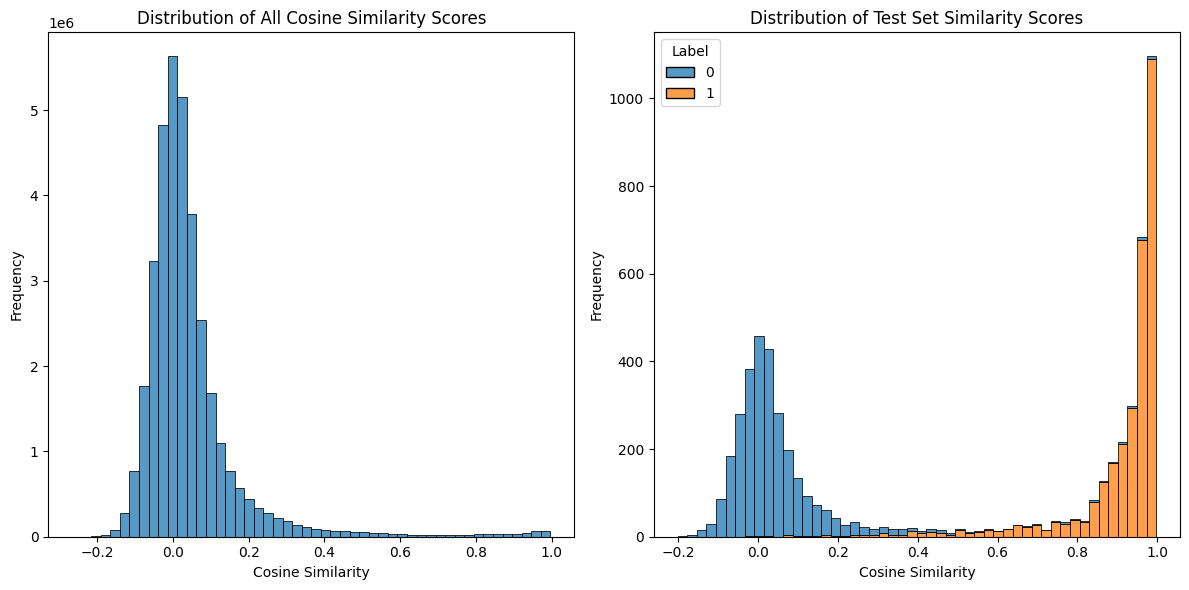


Similarity Score Statistics:
Mean similarity score: 0.0456
Median similarity score: 0.0159
Standard deviation: 0.1384
Min score: -0.2660
Max score: 0.9971

Proportion of similarity scores above thresholds:
Above 0.70: 1.23%
Above 0.80: 0.97%
Above 0.90: 0.62%
Above 0.95: 0.37%
Above 0.98: 0.12%

Top-5 match statistics:
Mean top-5 score: 0.9740
Min top-5 score: 0.7136
Max top-5 score: 0.9971


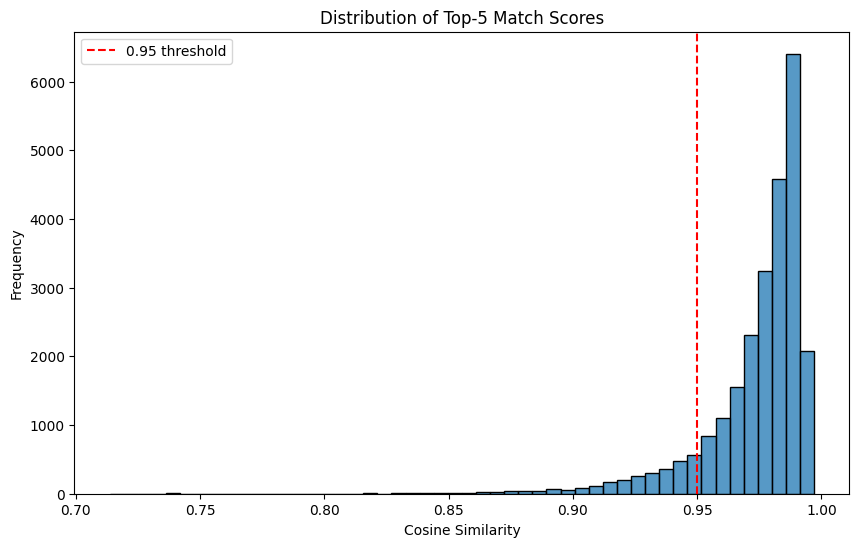

In [13]:
# First, we need to compute test_similarities and test_labels
# Extract the test examples' texts and labels
test_resume_texts = [example.texts[0] for example in test_examples]
test_job_texts = [example.texts[1] for example in test_examples]
test_labels = [int(example.label) for example in test_examples]

# Encode with fine-tuned model
test_resume_embeddings = model.encode(test_resume_texts, convert_to_numpy=True)
test_job_embeddings = model.encode(test_job_texts, convert_to_numpy=True)

# Calculate similarity scores
test_similarities = []
for i in range(len(test_resume_embeddings)):
    sim = cosine_similarity([test_resume_embeddings[i]], [test_job_embeddings[i]])[0][0]
    test_similarities.append(sim)

# Now proceed with the distribution analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of all similarity scores from the full dataset
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
all_similarities = similarity_matrix.flatten()
sns.histplot(all_similarities, bins=50)
plt.title('Distribution of All Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Plot distribution of test set similarity scores with colored labels
plt.subplot(1, 2, 2)
test_data = pd.DataFrame({
    'Similarity': test_similarities,
    'Label': test_labels
})
sns.histplot(data=test_data, x='Similarity', hue='Label', bins=50, multiple='stack')
plt.title('Distribution of Test Set Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Calculate some statistics about the distribution
print("\nSimilarity Score Statistics:")
print(f"Mean similarity score: {np.mean(all_similarities):.4f}")
print(f"Median similarity score: {np.median(all_similarities):.4f}")
print(f"Standard deviation: {np.std(all_similarities):.4f}")
print(f"Min score: {np.min(all_similarities):.4f}")
print(f"Max score: {np.max(all_similarities):.4f}")

# Check how many scores are above various thresholds
thresholds = [0.7, 0.8, 0.9, 0.95, 0.98]
print("\nProportion of similarity scores above thresholds:")
for t in thresholds:
    pct = np.mean(all_similarities > t) * 100
    print(f"Above {t:.2f}: {pct:.2f}%")

# Specifically check top job-resume match scores
top_scores = combined_df['Similarity_Score']
print("\nTop-5 match statistics:")
print(f"Mean top-5 score: {top_scores.mean():.4f}")
print(f"Min top-5 score: {top_scores.min():.4f}")
print(f"Max top-5 score: {top_scores.max():.4f}")

# Plot distribution of top-5 scores
plt.figure(figsize=(10, 6))
sns.histplot(top_scores, bins=50)
plt.title('Distribution of Top-5 Match Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.axvline(x=0.95, color='r', linestyle='--', label='0.95 threshold')
plt.legend()
plt.show()

In [14]:
# Compute classification report with fine-tuned model embeddings
from sklearn.metrics import classification_report

# We already have test_similarities and test_labels from the previous code

# Predict using threshold of 0.5
y_pred = [1 if score >= 0.5 else 0 for score in test_similarities]

# Generate classification report
print("Classification Report with Fine-tuned Model:")
print(classification_report(test_labels, y_pred, target_names=['No Match', 'Match']))

# You might also want to try different thresholds to see how they affect performance
print("\nTesting different thresholds:")
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
    print(f"\nThreshold: {threshold}")
    y_pred = [1 if score >= threshold else 0 for score in test_similarities]
    print(classification_report(test_labels, y_pred, target_names=['No Match', 'Match'], digits=4))

Classification Report with Fine-tuned Model:
              precision    recall  f1-score   support

    No Match       0.97      0.98      0.97      2952
       Match       0.98      0.97      0.97      3048

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000


Testing different thresholds:

Threshold: 0.5
              precision    recall  f1-score   support

    No Match     0.9663    0.9800    0.9731      2952
       Match     0.9804    0.9669    0.9736      3048

    accuracy                         0.9733      6000
   macro avg     0.9733    0.9734    0.9733      6000
weighted avg     0.9734    0.9733    0.9733      6000


Threshold: 0.6
              precision    recall  f1-score   support

    No Match     0.9512    0.9834    0.9670      2952
       Match     0.9834    0.9511    0.9670      3048

    accuracy                         0.9670      6000
   macro avg     0.9